### Simulation of auto-correlated data using Python
The following is a Python version of my R project found in
https://github.com/segreaves/R-RepeatedMeasuresDataSimulation.git

Project: Simulating Repeated Measures Data with Gender-Based Variability
Script:  repeated_measures_data_simulation.ipynb
Author:  Simon Greaves
Date:    17-AUG-2024
 
Description:
This script generates a simulated dataset of repeated measurements taken
from individual subjects over time, incorporating gender-based differences 
in baseline values and slopes. The simulation includes time-varying effects,
probabilistic no-shows (failed measurements that yield NA values),
and random intervals between measurement appointments.
This dataset can be used to validate statistical models and explore data
analysis techniques.

Dependencies:
- Python 3.12.3
- Modules: numpy, pandas, seaborn, matplotlib

Inputs:
- None

Outputs:
- A data set containing the repeated measurements by id in a LONG format.
- A plot visualizing the relationship between time and measurement values
stratified by gender.

Notes:
- Gender is modeled as a binary variable with equal probability.


In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Set up the parameters for the data simulation

In [2]:
# set random seed for reproducibility
np.random.seed(42)
# Number of individual id instances
n_instances = 10000
# Number of measurements
lambda_param = 0.75
# Probability of male gender
prob_male = 0.5
# Measurement baseline, gender offsets, and slopes
baseline = 100
male_baseline_offset = 10
slope = -0.25
male_slope_offset = -0.1
# Probability of successful measurement
measurement_prob = 0.9
# Maximum days between measurements
max_days = 7

Create the wide version of the dataset. This will contain only the high level
variables of the individual, like gender, number of measurements, and the slope
offset of the individual

In [56]:
# Set up individual profiles
wide = pd.DataFrame({
    'id': np.arange(1, n_instances + 1),
    'total_measurements': np.ceil(np.random.exponential(1/lambda_param, n_instances)).astype(int),
    'gender': np.random.binomial(1, prob_male, n_instances),
    'id_offset': np.random.normal(0, 1, n_instances)
})
# Create numeric sex variable
wide['sex'] = wide['gender'].map({0: 'F', 1: 'M'})

Convert the data format from wide to long. Then add the other simulated
variables, such as days between measurements, whether the measurement was
successful (obtained a value), and other useful variables

In [57]:
# Create measurements data set with as many rows as measurements
long = wide.loc[wide.index.repeat(wide['total_measurements'])].reset_index(drop=True)
# Add days between measurements
long['days'] = np.random.uniform(0, max_days, len(long))
# Group by id for cumulative operations
long['day'] = long.groupby('id')['days'].cumsum()
long['n_appointment'] = long.groupby('id').cumcount() + 1

# Simulate measurement success
long['successful_measurement'] = np.random.binomial(1, measurement_prob, len(long))
long['n_measurements'] = long.groupby('id')['successful_measurement'].cumsum()
long['n_successful_measurements'] = long.groupby('id')['successful_measurement'].transform('sum')

# Calculate measurement value
long['value'] = np.where(
    long['successful_measurement'] == 1,
    baseline + long['id_offset'] + long['gender'] * male_baseline_offset + 
    slope * long['day'] + long['gender'] * male_slope_offset * long['day'] + 
    np.random.normal(0, 1, len(long)),
    np.nan
)

Plot the data and add regression lines by group

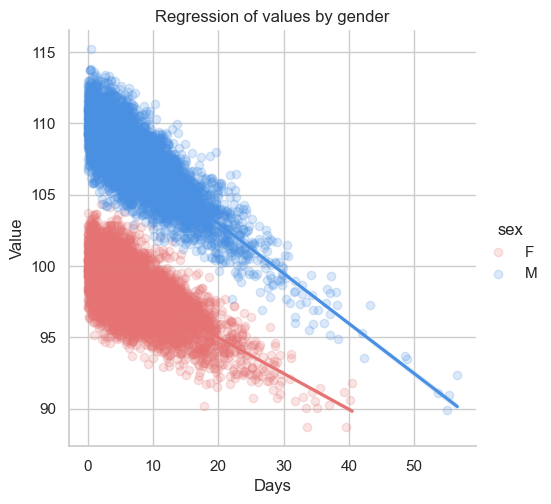

In [63]:
# Plot the data grouped by sex. Add some transparency as well
fig = sns.lmplot(x='day',
                 y='value',
                 hue='sex',
                 palette={'M': '#4a90e2', 'F': '#e57373'},
                 scatter_kws={'alpha': 0.2},
                 data=long)

# Add title
plt.title('Regression of values by gender')
# Set x and y labels
fig.set_axis_labels('Days', 'Value')
